In [2]:
import os
os.chdir('modules')
from train import train, score
from get_data import get_data
from model import LangID, LogisticRegression, ComplementNB, BernoulliNB
from get_gpt_reviews import get_gpt_reviews
import matplotlib.pyplot as plt
from random import shuffle
import numpy as np
Xt, Yt = get_data("dev")

Device used = cuda


Augmented 'x' size of original: 5.229 for size 2000


D:\Users\Christoffer\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Users\Christoffer\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

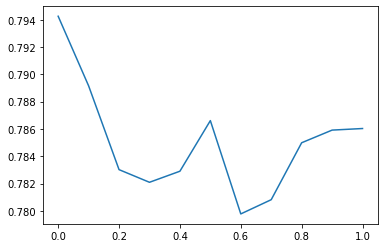

In [45]:
import numpy as np
for size in [2000]:
    X_all, Y_all = get_data("gpt_" + str(size))
    assert len(get_data("n_" + str(size))) == size # Should be 2000 in the end
    new_len = len(X_all) - size
    print("Augmented 'x' size of original:", new_len/size, "for size", size)
    ps, scores = [], []
    for i in range(0, 101, 10):
        p = i/100
        data_size = int(size + p*new_len) # exclusive to avoid indexing [-1:]
        X, Y = X_all[-data_size:], Y_all[-data_size:]
        model = LogisticRegression(max_iter=100)
        model.fit(X, Y)
        acc = (model.predict(Xt) == np.array(Yt)).mean()
        scores.append(acc)
        ps.append(p)
    plt.plot(ps, scores)
    plt.show()

In [4]:
from get_data import get_data

ModuleNotFoundError: No module named 'get_data'

Length of vocab: 3921
Number of epochs = 15, Loss=2.742
Accuracy on dev set=0.588
Length of vocab: 4816
Number of epochs = 15, Loss=5.035
Accuracy on dev set=0.59
Length of vocab: 5517
Number of epochs = 15, Loss=6.145
Accuracy on dev set=0.622
Length of vocab: 6065
Number of epochs = 15, Loss=7.266
Accuracy on dev set=0.594
Length of vocab: 6496
Number of epochs = 15, Loss=10.635
Accuracy on dev set=0.593
Length of vocab: 6971
Number of epochs = 15, Loss=12.247
Accuracy on dev set=0.597
Length of vocab: 7364
Number of epochs = 15, Loss=15.883
Accuracy on dev set=0.59
Length of vocab: 7696
Number of epochs = 15, Loss=15.973
Accuracy on dev set=0.61
Length of vocab: 7955
Number of epochs = 15, Loss=21.422
Accuracy on dev set=0.593


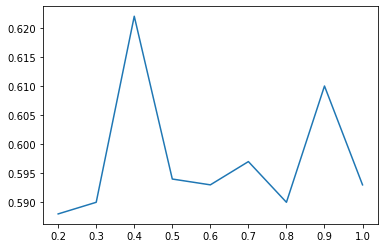

In [17]:
ps, scores = [], []
for i in range(20, 101, 10):
    p = i/100
    data_size = int(base_len + p*new_len - 1) # exclusive to avoid indexing [-1:]
    data = list(zip(X_all[-data_size:], Y_all[-data_size:])) # Go from back, so we always get base data
    shuffle(data)
    X, Y = zip(*data)
    model, vocab = train(X, Y, epochs=15, embed_dim=100, lstm_dim=100, min_df=0., max_df=1., batch_size=64)
    
    scores.append(score(model, vocab, Xt, Yt))
    ps.append(p)
plt.plot(ps, scores)
plt.show()

Length of vocab: 2784
Number of epochs = 20, Loss=1.940
Accuracy on dev set=0.56
Length of vocab: 3178
Number of epochs = 20, Loss=2.531
Accuracy on dev set=0.569
Length of vocab: 3573
Number of epochs = 20, Loss=3.019
Accuracy on dev set=0.609
Length of vocab: 3929
Number of epochs = 20, Loss=3.006
Accuracy on dev set=0.648
Length of vocab: 4239
Number of epochs = 20, Loss=2.839
Accuracy on dev set=0.649
Length of vocab: 4512
Number of epochs = 20, Loss=3.467
Accuracy on dev set=0.666


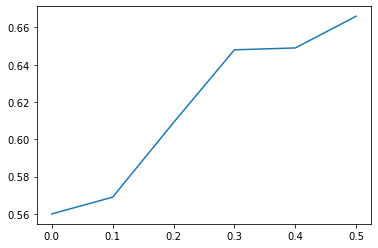

In [4]:
for min_df in [0]:
    ps, scores = [], []
    for i in range(0, 51, 10):
        p = i/100
        data_size = int(base_len + p*new_len - 1) # exclusive to avoid indexing [-1:]
        X = X_all[-data_size:] # Go from back, so we always get base data
        Y = Y_all[-data_size:]

        model, vocab = train(X, Y, epochs=20, embed_dim=100, lstm_dim=100, min_df=3, batch_size=512)
        scores.append(score(model, vocab, Xt, Yt))
        ps.append(p)
    plt.plot(ps, scores)
    plt.show()

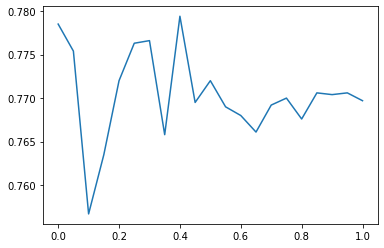

In [8]:
class OnehotTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def convert(self, sentence):# [[w1, w2, w3], [w1, w2, w3]]
        output = [0]*len(self.vocab)
        for word in sentence.split():
            word = word.lower()
            if word in self.vocab:
                output[self.vocab[word]] = 1
        return output

    def fit(self, X, y=None):
        vectorizer = TfidfVectorizer(min_df = 25)
        vectorizer.fit(X)
        self.vocab = vectorizer.vocabulary_
        return self
    
    def transform(self, X, y=None):
        X_ = [self.convert(row) for row in X]
        return X_

ps, scores = [], []
for i in range(0, 101, 5):
    p = i/100
    data_size = int(base_len + p*new_len - 1) # exclusive to avoid indexing [-1:]
    X = X_all[-data_size:] # Go from back, so we always get base data
    Y = Y_all[-data_size:]

    pipe = Pipeline([
        ('onehot', OnehotTransformer()),
        ('clf', LogisticRegression(max_iter=1000))
    ])
    pipe.fit(X, Y)
    
    scores.append(pipe.score(Xt, Yt))
    ps.append(p)
plt.plot(ps, scores)

In [6]:
get_data("gpt_100")

(["i love the song! it's a beautiful song. i would like to have this song on my car radio.",
  "i really liked this song. it's a nice change of pace from the other songs in the collection, and it's a very nice ballad.",
  'i love it when she sings into the microphone. it really adds a new dimension to her voice.',
  'i love miley cyrus!',
  "wow.  i couldn't even make it through the whole thing.  definitely not my cup of tea i guess.",
  "this is not a good album.  it's a waste of time.  i don't understand why anyone would listen to this album.  i'm not a fan of bonnie tyler.  this song is horrible.  i don't know how anyone can listen to this.  i'm not a fan of the pretenders either.  the lyrics are terrible.  this is not worth the money.  i don't understand why anyone would want to listen to this.  this album is a waste of time.",
  "this is a good song, but the version i heard was too loud.  i am glad, because i don't like loud music.",
  "i ordered this cd based on a friend's recomm

In [8]:
X, Y = get_data("gpt_" + str(100))
ps, scores = [], []
model = LogisticRegression(max_iter=100)
model.fit(X, Y)
probs = model.predict_proba(X)

D:\Users\Christoffer\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [33]:
# p = 0.1 (of being positive)
# l = 1 (positive)

# p - l -> abs(0.01 - 1) > 0.5 
# Will catch wrong predictions
#idxs = sorted((p, l, i) for p, l, i in zip(probs[:,0], Y, range(len(probs))) if abs(p - l) < 0.5)
idxs = sorted((p, i) for p, l, i in zip(probs[:,1], Y, range(len(probs))) if abs(p - l) > 0.5)

In [ ]:
size = 500
for del_p in range(0, 51, 10):
    del_size = int((del_p / 100)*len(idxs))//2
    del_idxs = set(idxs[:del_size] + idxs[-del_size:])
    print(len(del_idxs))
    
    X_all, Y_all = get_data("gpt_" + str(size))
    X_all = [x for i, x in enumerate(X_all) if i not in del_idxs]
    Y_all = [y for i, y in enumerate(Y_all) if i not in del_idxs]
    
    new_len = len(X_all) - size
    ps, scores = [], []
    for i in range(0, 101, 10):
        p = i/100
        data_size = int(size + p*new_len) # exclusive to avoid indexing [-1:]
        X, Y = X_all[-data_size:], Y_all[-data_size:]
        model = LogisticRegression(max_iter=100)
        model.fit(X, Y)
        acc = (model.predict(Xt) == np.array(Yt)).mean()
        scores.append(acc)
        ps.append(p)
    plt.plot(ps, scores)
    plt.title('Percentage of poor labels deleted: ' + str(del_p))
    plt.show()

1164


D:\Users\Christoffer\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Users\Christoffer\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi